In [8]:
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np
import pandas as pd
from spectrum import *

import matplotlib
import matplotlib.pyplot as plt

In [9]:
def plot_heatmap(data, x_labels, y_labels, title):
    fig, ax = plt.subplots()
    im = ax.imshow(data)
    cbar = ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_title(title)

In [10]:
# load data
data = loadmat('data/allEMGdata-JuniperSun-0323new.mat', squeeze_me=True, struct_as_record=False)
X_raw = data['EMG'].data
X_raw = X_raw.astype(np.float32)
X_raw = np.moveaxis(X_raw, -1, 0)
X_raw = np.moveaxis(X_raw, -1, 1)

y = data['EMG'].epochlabels
y_people = np.repeat(np.arange(10), 18)

times = data['EMG'].alltimes
times = np.moveaxis(times, -1, 0)

channels = [0, 1, 2]

print("times.shape", times.shape)
print("X_raw.shape", X_raw.shape)
print("y.shape", y.shape)
print("y_people.shape", y_people.shape)


times.shape (18, 1500)
X_raw.shape (180, 1500, 3)
y.shape (180,)
y_people.shape (180,)


In [11]:
# Apply Second Order Buttersworth Band Pass Filter
# https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

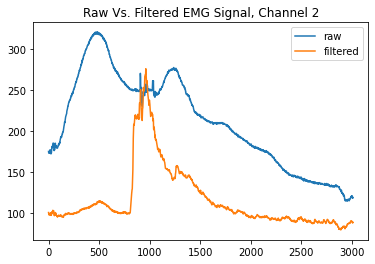

In [20]:
# Apply Filtering with cutoff frequencies of 20Hz and 1Hz
# https://www.sciencedirect.com/science/article/pii/S1474667015304596

fs = 500
lowcut = 20
highcut = 100
X = butter_bandpass_filter(X_raw, lowcut, highcut, fs, order=2)

# Plot one EMG signal
plt.figure()
plt.plot(times[0], X_raw[0, :, 2])
plt.plot(times[0], X[0, :, 2])
plt.title("Raw Vs. Filtered EMG Signal, Channel 2")
plt.legend(["raw", "filtered"])

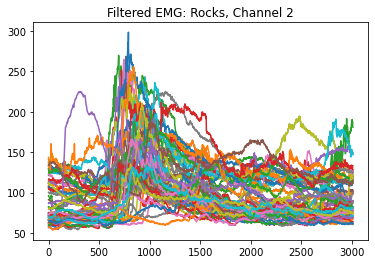

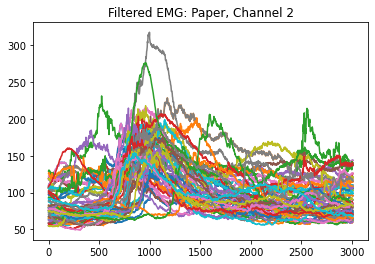

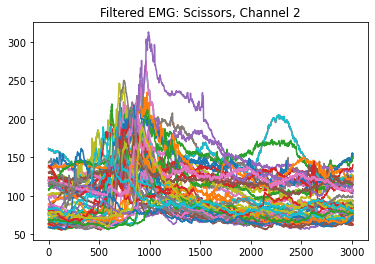

In [21]:
ch = 2
sel_times = times[0]

plt.figure()
plt.title("Filtered EMG: Rocks, Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "rock"):
        plt.plot(sel_times, X[i, :, ch])

plt.figure()
plt.title("Filtered EMG: Paper, Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "paper"):
        plt.plot(sel_times, X[i, :, ch])

plt.figure()
plt.title("Filtered EMG: Scissors, Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "scissors"):
        plt.plot(sel_times, X[i, :, ch])

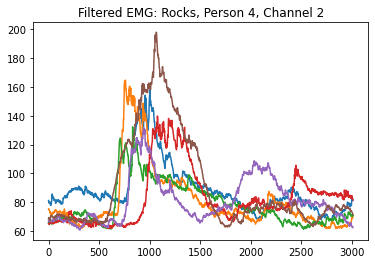

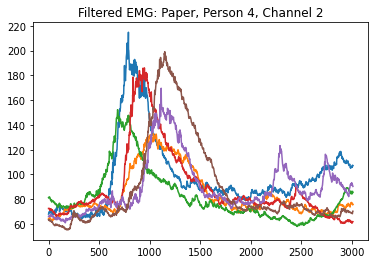

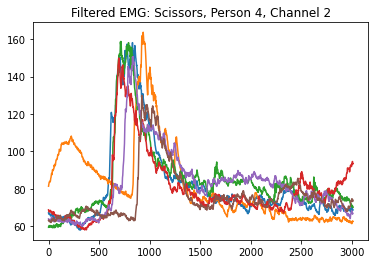

In [22]:
# plot by person
# assumption that signals of a person are closer together
ch = 2
person = 4

plt.figure()
plt.title("Filtered EMG: Rocks, Person " + str(person) + ", Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "rock" and y_people[i] == person):
        plt.plot(times[0], X[i, :, ch])

plt.figure()
plt.title("Filtered EMG: Paper, Person " + str(person) + ", Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "paper" and y_people[i] == person):
        plt.plot(times[0], X[i, :, ch])

plt.figure()
plt.title("Filtered EMG: Scissors, Person " + str(person) + ", Channel " + str(ch))
for i in range(X.shape[0]):
    if (y[i] == "scissors" and y_people[i] == person):
        plt.plot(times[0], X[i, :, ch])

In [23]:
# fit linear autoregressive (AR) model to filtered EMG
# use Burgs algorithm to calculate coefficients
# test out p = order 2, 3, 4, 5, 6

# p_orders = [2, 3, 4, 5, 6]
p_orders = [10, 16, 30]
ar_coefs = []

for p in p_orders:
    ar_coefs.append(np.zeros((X.shape[0], p, len(channels))))

for i in range(X.shape[0]):
    for p, p_order in enumerate(p_orders):
        for r in channels:
            AR, _, _ = arburg(X[i, :, r], p_order)
            ar_coefs[p][i, :, r] = AR

# reshape AR coefficients to be a vector of shape p x r
ar_coefs_flat = []
for p, p_order in enumerate(p_orders):
    ar_coefs_flat.append(ar_coefs[p].reshape(ar_coefs[p].shape[0], -1))
    print(ar_coefs_flat[p].shape)

ar_coefs_flat[2]

# save AR coefficients
for p, p_order in enumerate(p_orders):
    filename = "data/AR_coef_p_order_{p_order}.csv".format(p_order = p_order)
    np.savetxt(filename, ar_coefs_flat[p], delimiter=',')

<ipython-input-23-1124a667f7b8>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  ar_coefs[p][i, :, r] = AR
(180, 30)
(180, 48)
(180, 90)


In [49]:
# calculate RMS
X_rms = np.sqrt(np.mean(np.square(X), axis=1))
print(X_rms.shape)

# save RMS
np.savetxt("data/RMS.csv", X_rms, delimiter=',')

(180, 3)


In [7]:
# save labels
y_categorical = []
for i, v in enumerate(y):
    if v == "rock":
        y_categorical.append(0)
    if v == "paper":
        y_categorical.append(1)
    if v =="scissors":
        y_categorical.append(2)
print(y_categorical)

filename = "data/labels_actions.csv"
np.savetxt(filename, y_categorical, delimiter=',')

filename = "data/labels_people.csv"
np.savetxt(filename, y_people, delimiter=',')

[2, 0, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1]
